Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

- Potato -> Healthy, Early Blight() and Late Blight(Microogranism)

Data
Data Cleaning and Preprocessing -> tf Dataset, Data Augmentation(More training samples)
Model Building -> CNN
Export Trained model to disk
MLOPs -> tfserving API use

Quantization -> Tf Model -> Tf lite model
Deploy to Google Cloud Fucntions. <--- Application use this deployed

Import data into tensorflow dataset object

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
import zipfile
import os

with zipfile.ZipFile("/content/PlantVillage-PotatoDisease.zip", 'r') as zip_ref:
    zip_ref.extractall("PotatoDatasett")

In [4]:
! rm -rf "/content/PotatoDatasett/__MACOSX"

We will use image_dataset_from_directory api to load all images in tensorflow dataset:
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [32]:
IMAGE_SIZE=256 #use by tf dataset
BATCH_SIZE=32
RGB_CHANNELS=3
EPOCHS=30

In [5]:
# Directly using tf dataset for all images
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PotatoDatasett/PlantVillage-PotatoDisease",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
# return a tf.data.Dataset with len = number of batches
# tf dataset already deals with batches
# .filer .map

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names
# Basically folder names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
print("total number of batches",len(dataset))
# total batches if len*32 approx size of all data

total number of batches 68


In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    # print(image_batch[0])
    # visualize using plt
    # plt.imshow(image_batch[0].numpy().astype("uint8"))
    # plt.title(labels_batch[0].numpy())
    # classnames[label[index]]
    print(labels_batch.numpy())

# Each batch 32 images
# and labels of that image belong to which class

(32, 256, 256, 3)
[2 0 2 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 2 0 0 0 0 1 1 0 1 0 1]


Visualize some of the images from our dataset

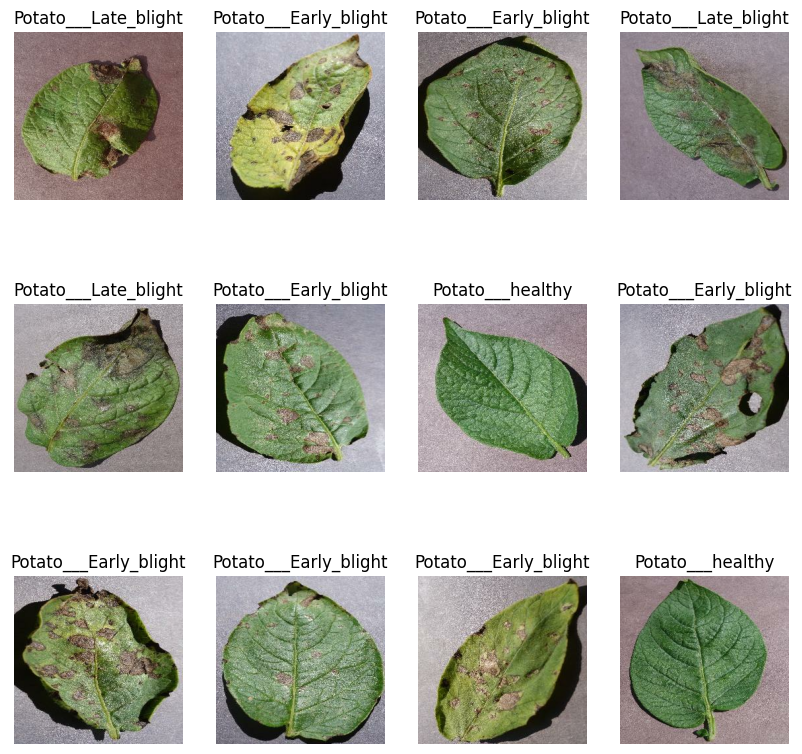

In [16]:
# printing 12 images 3*4 rows type with labels
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12,12+12):
        ax = plt.subplot(3, 4, i-12 + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Train 80% Validation 10% Test 10%
- dataset is total batch unhi mein baaton

In [17]:
len(dataset)

68

In [18]:
print(68*0.8)
print(68*0.1)

54.400000000000006
6.800000000000001


In [19]:
train_ds = dataset.take(54)
test_ds=dataset.skip(54) # after 54 rest

In [20]:
validation_ds= test_ds.take(6)
test_ds=test_ds.skip(6) # rest inside test

Same Train Test Split using function

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    # aset makes sure condfition is true before going inside the funtion
    ds_size = len(ds)

    # shuffle the ds complety
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


Prefetch and Cache in Tf Dataset
- while cpu busy gpu concept
- load images before hand
- buffer_size=tf.data.AUTOTUNE let tf decide how many images to load beforehand

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Images -> Scaling /255 -> Data Augmentation sample images rotated zoomed

## Building the Model
- Sequential layers
- Layer1- resize and rescale
- Layer2 - data augmentation original imagte : rotate, contrast, zoom

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

# why resizing we already did while extracting tf dataset
# if predict random image then it goes thorough this layer

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, RGB_CHANNELS)
n_classes = 3

# since we provide tf_dataset.take(0) --> 32 bathc image hai each
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()
# Paramsa are number of weights to be trained

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=1,
)
# recording in history of each epoch
# verbose=1 prints training and validation progress with a progress bar
# use this history to plot loss accuracy boom boom

54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.9650 - loss: 0.0906 - val_accuracy: 0.9583 - val_loss: 0.1019


In [39]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9614 - loss: 0.1384


In [40]:
scores

[0.08717799931764603, 0.9765625]

Plotting the Accuracy and Loss Curves

In [41]:
history

In [42]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 54}

In [43]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [44]:
history.history['loss'][:5]

[0.09087967872619629]

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

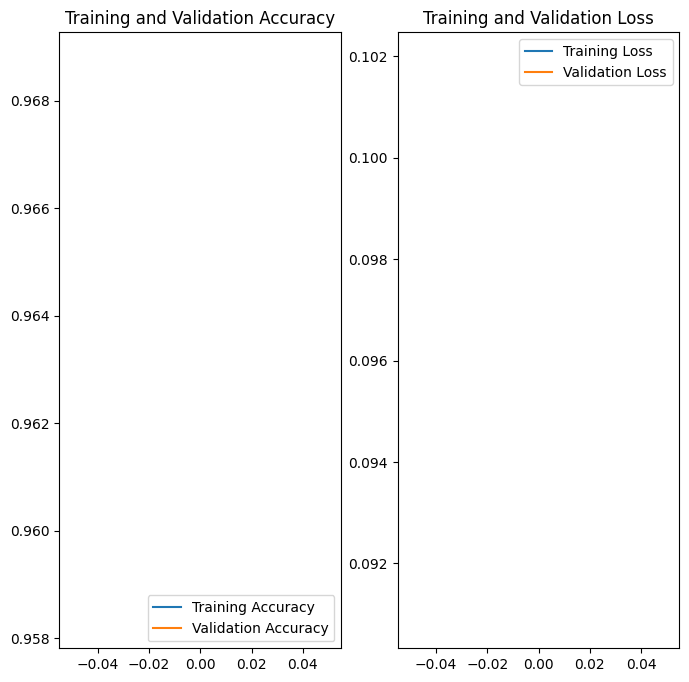

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1), acc, label='Training Accuracy')
plt.plot(range(1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1), loss, label='Training Loss')
plt.plot(range(1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[8.31003666e-01 1.65685698e-01 3.31062265e-03]
 [9.99887288e-01 1.12498950e-04 7.40390789e-08]
 [9.83537853e-01 1.64620895e-02 1.12166433e-07]
 [1.37258094e-05 9.99985874e-01 3.17433575e-07]
 [9.94484723e-01 5.51100122e-03 4.31869876e-06]
 [7.02123996e-03 9.92518961e-01 4.59915755e-04]
 [9.99998987e-01 9.76253659e-07 1.79876444e-11]
 [4.44077778e-05 9.99561131e-01 3.94353148e-04]
 [9.99972045e-01 2.78652587e-05 2.39506779e-08]
 [1.75580494e-02 9.81989741e-01 4.52185690e-04]
 [1.43922980e-05 9.99980628e-01 4.89801232e-06]
 [9.99998748e-01 1.15505429e-06 3.04458299e-11]
 [8.98393169e-02 9.10160244e-01 3.57128442e-07]
 [1.92511827e-03 9.98065591e-01 9.23488915e-06]
 [8.38935912e-01 1.60533503e-01 5.30674995e-04]
 [9.99991834e-01 8.08993900e-06 1.34393649e-10]
 [9.99998987e-01 9.60843295e-07 4.74191908e-10]
 [1.31635143e-05 9.99980271e-01 6.58695990e-06]
 [5.40534794e-01 3.69750440e-01 8.9714802

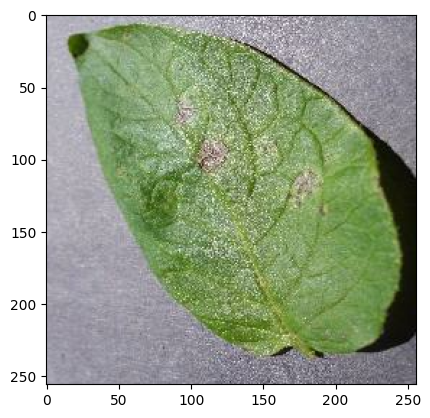

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(batch_prediction)
    # complete batch prediction with each value probability of output 3 classes
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference
- need input as batch since thats way we have layered model predict
- output as batch array

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    # prediction is in batch type so index 0
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


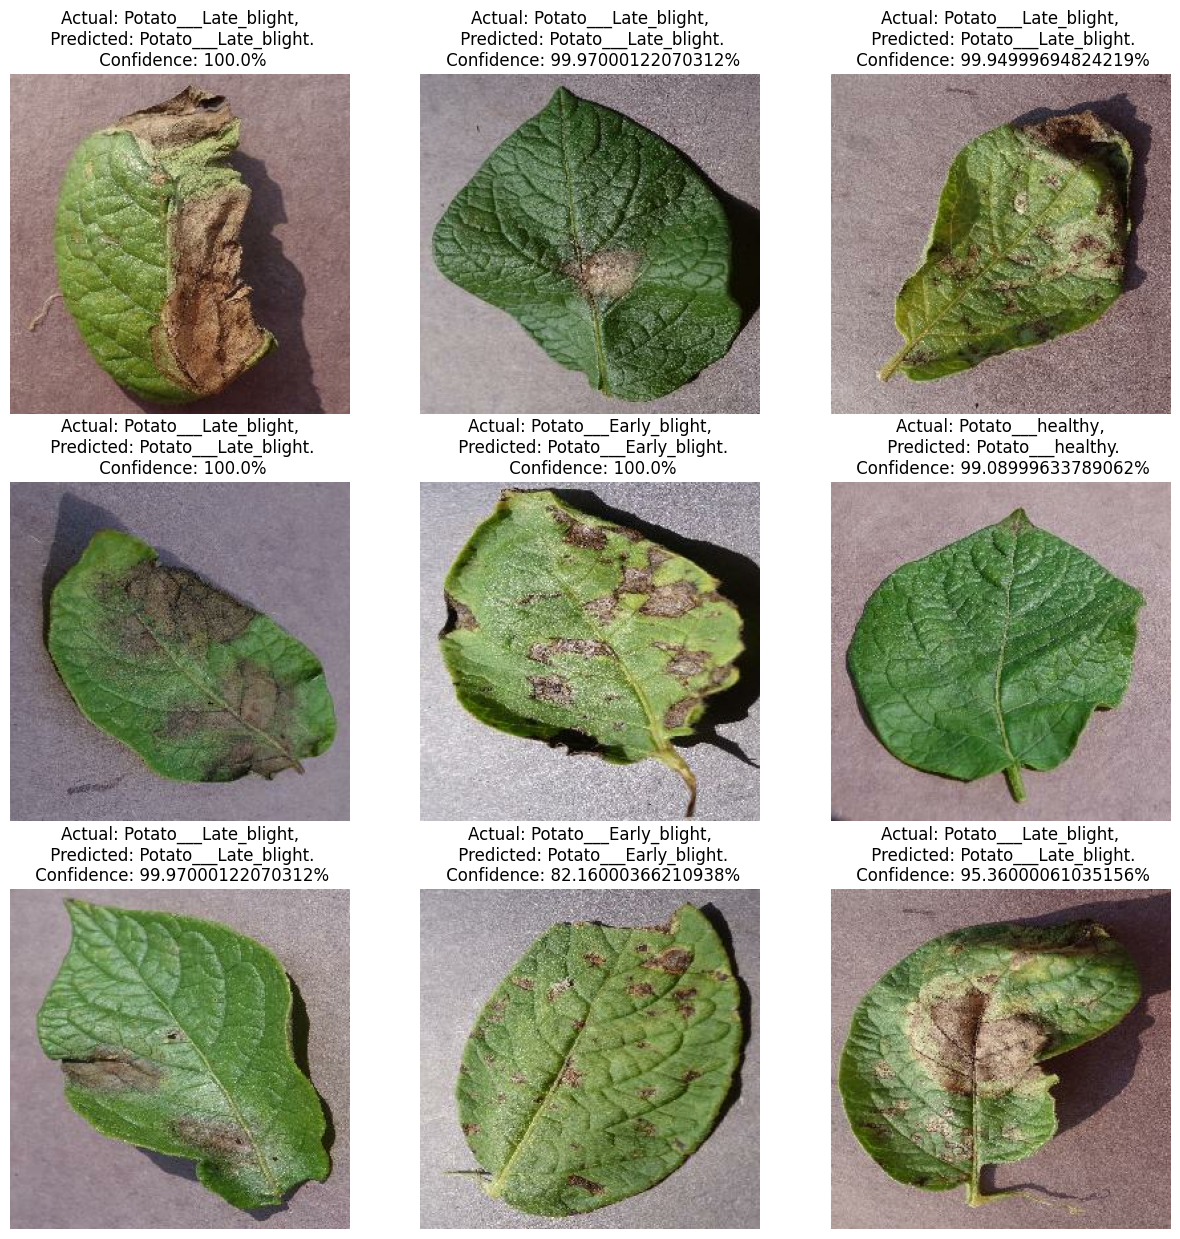

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Plot inside subplot divide
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Saving the model of Keras after training

In [59]:
model.save("/content/Potato/my_model.keras")

In [60]:
model.save("/content/Potato/my_model.h5")
# for tf model

In [62]:
model.export("/content/Potato/my_model/")

Saved artifact at '/content/Potato/my_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138796015687760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015687952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015692368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015693136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015691792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015690256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015694288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015693520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015693328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138796015695248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13879